# Leave-One-Patient-Out classification of individual volumes

Here, we train a classifier for each patient, based on the data of all the other patients except the current one (Leave One Out Cross-Validation). To this end, we treat each volume as an independent observation, so we have a very large sample of volumes which are used for training; and later, we do not classify the patient as a whole, but the classifier makes a decision for each of the held-out patient's 200 volumes. Therefore, at this stage, we have not made a decision on the patient level, but only at the volume-as-unit-of-observation level.

### import modules

In [1]:
import os
import pickle

import numpy as np
import pandas as pd

from sklearn import svm, preprocessing, metrics
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks')
sns.set_context('poster')

In [2]:
sns.set_context('poster')

In [3]:
# after converstion to .py, we can use __file__ to get the module folder
try:
    thisDir = os.path.realpath(__file__)
# in notebook form, we take the current working directory (we need to be in 'notebooks/' for this!)
except:
    thisDir = '.'
# convert relative path into absolute path, so this will work with notebooks and py modules
supDir = os.path.abspath(os.path.join(os.path.dirname(thisDir), '..'))

supDir

'/data/martin/volume-wise-language'

### get meta df

We need this e.g. to get information about conclusiveness

In [4]:
data_df = pd.read_csv(
    '../data/interim/csv/info_epi_zscored_zdiff_summarymaps_2dpredclean_corr_df.csv',
    index_col=[0, 1],
    header=0)

In [ ]:
data_df.tail()

#### conclusiveness filters

In [6]:
is_conclusive = data_df.loc[:, 'pred'] != 'inconclusive'

In [7]:
is_conclusive.sum()

63

### get data

In [8]:
def make_group_df(data_df,metric='corr_df'):
    '''load correlation data of all patients'''
    
    group_df = pd.DataFrame()
    
    for p in data_df.index:
        # get data
        filename = data_df.loc[p, metric]
        this_df = pd.read_csv(filename, index_col=[0], header=0)
        # add patient infos to index
        this_df.index = [[p[0]], [p[1]]]
        
        group_df = pd.concat([group_df, this_df])

    # reorder the colums and make sure volumes are integer values
    group_df.columns = group_df.columns.astype(int)
    
    # sort across rows, then across columns, to make sure that volumes
    # are in the right order
    group_df = group_df.sort_index(axis=0)
    group_df = group_df.sort_index(axis=1)

    assert all(group_df.columns == range(200)), 'wrong order of volumes'
            
    return group_df

In [9]:
group_df = make_group_df(data_df)

In [ ]:
group_df.tail()

#### filter data

In [11]:
# only conclusive cases
conclusive_df = group_df[is_conclusive]
# only inconclusive cases
inconclusive_df = group_df[is_conclusive == False]
# all cases unfiltered
withinconclusive_df = group_df.copy()

In [12]:
print(conclusive_df.shape, inconclusive_df.shape, withinconclusive_df.shape)

(63, 200) (33, 200) (96, 200)


### get design

In [13]:
conds_file = os.path.join(supDir,'models','conds.p')
with open(conds_file, 'rb') as f:
    conds = pickle.load(f)

In [14]:
print(conds)

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1]


### get colors

In [15]:
with open('../models/colors.p', 'rb') as f:
    color_dict = pickle.load(f)
    
my_cols = {}
for i, j in zip(['red', 'blue', 'yellow'], ['left', 'right', 'bilateral']):
    my_cols[j] = color_dict[i]

### invert the resting timepoints

In [16]:
inv_df = conclusive_df*conds

In [ ]:
inv_df.tail()

### train the classifier

In [ ]:
stack_df = pd.DataFrame(inv_df.stack())
stack_df.tail()

In [19]:
stack_df.shape

(12600, 1)

In [20]:
my_groups = ['left','bilateral','right']

/data/condaEnvs/volumeAnalysis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


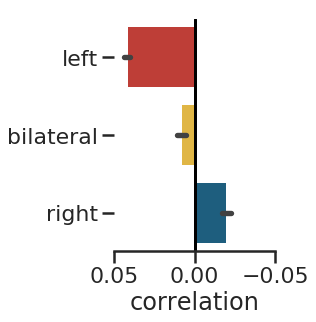

In [21]:
dynamite_df = stack_df.copy()
dynamite_df.columns = ['correlation']
dynamite_df['group'] = dynamite_df.index.get_level_values(0)
sns.catplot(data=dynamite_df,y='group',x='correlation',kind='bar',orient='h',palette=my_cols,order=my_groups,aspect=1)
plt.axvline(0,color='k',linewidth=3)
plt.xlim(0.05,-0.05,-0.01)
sns.despine(left=True,trim=True)
plt.ylabel('')
plt.savefig('../reports/figures/10-dynamite-plot.png',dpi=300,bbox_inches='tight')
plt.show()

In [22]:
from scipy import stats

In [23]:
t,p = stats.ttest_ind(dynamite_df.loc['bilateral','correlation'],dynamite_df.loc['left','correlation'])
print('\nt=%.2f,p=%.64f'%(t,p))
t,p = stats.ttest_ind(dynamite_df.loc['bilateral','correlation'],dynamite_df.loc['right','correlation'])
print('\nt=%.2f,p=%.38f'%(t,p))
t,p = stats.ttest_ind(dynamite_df.loc['left','correlation'],dynamite_df.loc['right','correlation'])
print('\nt=%.2f,p=%.248f'%(t,p))


t=-17.10,p=0.0000000000000000000000000000000000000000000000000000000000000001

t=12.98,p=0.00000000000000000000000000000000000006

t=34.56,p=0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000004


###  as histogram

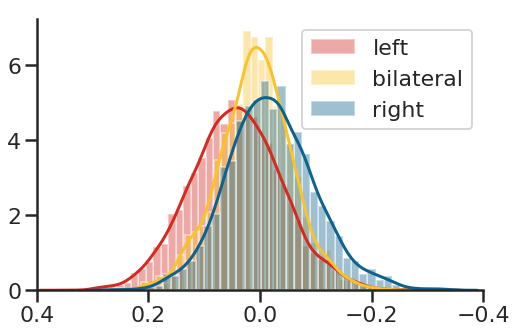

In [24]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
for group in my_groups:
    sns.distplot(stack_df.loc[group,:],color=my_cols[group],label=group,ax=ax)
plt.legend()
plt.xlim(0.4,-0.4,-0.2)
sns.despine()
plt.show()

### set up the classifier

In [25]:
clf = svm.SVC(kernel='linear',C=1.0,probability=False,class_weight='balanced')

In [26]:
def scale_features(X):
    '''z-transform the features before applying a SVC.
    The scaler is also stored so it can later be re-used on test data'''
    my_scaler = preprocessing.StandardScaler()
    my_scaler.fit(X)
    X_scaled = my_scaler.transform(X)
    return X_scaled,my_scaler

In [27]:
def encode_labels(y):
    '''get from number labels to strings and back'''
    my_labeler = preprocessing.LabelEncoder()
    my_labeler.fit(np.unique(y))
    y_labels = my_labeler.transform(y)
    return y_labels, my_labeler

In [28]:
def train_classifier(df):
    '''get features and labels
    * scale the features
    * transform the labels
    * apply the classifier
    '''

    X = df.values
    y = df.index.get_level_values(0)

    X_scaled,my_scaler = scale_features(X)
    y_labels, my_labeler = encode_labels(y)

    clf.fit(X_scaled,y_labels)
    
    return clf,my_scaler,my_labeler

In [29]:
example_clf, example_scaler, example_labeler = train_classifier(stack_df)

In [30]:
example_clf

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [31]:
example_scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [32]:
example_labeler.classes_

array(['bilateral', 'left', 'right'], dtype=object)

In [33]:
def get_boundaries(clf,my_scaler):
    '''find the point where the classifier changes its prediction;
    this is an ugly brute-force approach and probably there is a much
    easier way to do this
    '''
    
    d = {}
    for i in np.linspace(-1,1,10000):
        this_val = my_scaler.transform(np.array([i]).reshape(1,-1))
        this_predict = clf.predict(this_val)
        d[i] = this_predict[-1]
    df = pd.DataFrame(d,index=['pred']).T
    return df[(df-df.shift(1))!=0].dropna().index[1:]

In [34]:
from datetime import datetime

### get class boundaries of all folds

In [35]:
import tqdm

In [36]:
def get_all_boundaries(stack_df):
    '''for each fold, get the boundaries, by
    training on everybody but the held-out patient
    and storing the boundaries'''
    
    all_boundaries = {}

    conclusive_pats = np.unique(stack_df.index.get_level_values(1))
    
    for p in tqdm.tqdm(conclusive_pats):

        # in the current fold, we drop one patient
        df = stack_df.drop(p,level=1)

        # train on this fold's data
        clf,my_scaler,my_labeler = train_classifier(df)
        
        # get the classifier boundaries
        boundaries = get_boundaries(clf,my_scaler)
        all_boundaries[p] = boundaries
        
    return all_boundaries

Compute the boundaries and store them for later re-use:

In [ ]:
all_boundaries = get_all_boundaries(stack_df)
bound_df = pd.DataFrame(all_boundaries).T
bound_df.tail()

In [38]:
bound_df.to_csv('../data/processed/csv/bound_df.csv')

To make things faster, we can re-load the computed boundaries here:

In [ ]:
bound_df = pd.read_csv('../data/processed/csv/bound_df.csv',index_col=[0],header=0)
bound_df.tail()

rename so boundaries have meaningful descriptions:

In [ ]:
bound_df = bound_df.rename(columns={'0':'B/R','1':'L/B'})
bound_df.tail()

In [41]:
bound_df.describe()

,B/R,L/B
count,63.000000,63.000000
mean,-0.014422,0.036100
std,0.001315,0.000881
min,-0.020902,0.034503
25%,-0.014501,0.035804
50%,-0.014501,0.036104
75%,-0.014501,0.036304
max,-0.009301,0.041304


#### show the class boundaries overlaid on the data distribution

/data/condaEnvs/volumeAnalysis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


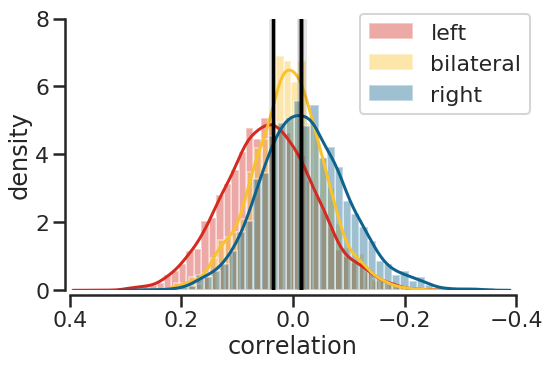

In [42]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
for group in my_groups:
    sns.distplot(stack_df.loc[group,:],color=my_cols[group],label=group,ax=ax)
    
for b in bound_df.values.flatten():
    plt.axvline(b,alpha=0.1,color=color_dict['black'])
    
plt.legend()
plt.xlabel('correlation')
plt.ylabel('density')
plt.xlim(0.4,-0.4,-0.2)
plt.ylim(0,8)
plt.legend(loc=(0.65,0.65))
sns.despine(trim=True,offset=5)
plt.savefig('../reports/figures/10-distribution-plot.png',dpi=300,bbox_inches='tight')
plt.show()

#### make swarm/factorplot with boundary values

In [43]:
sns_df = pd.DataFrame(bound_df.stack())
sns_df.columns = ['correlation']
sns_df.loc[:,'boundary'] = sns_df.index.get_level_values(1)
sns_df.loc[:,'dummy'] = 0

In [ ]:
sns_df.tail()

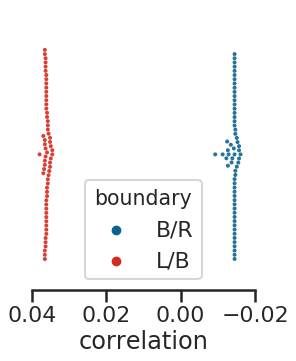

In [45]:
fig,ax = plt.subplots(1,1,figsize=(4,5))
sns.swarmplot(data=sns_df,
              x='correlation',
              y='dummy',
              hue='boundary',
              orient='h',
              palette={'L/B':my_cols['left'],'B/R':my_cols['right']},
              size=4,
              alpha=0.9,
              ax=ax
             )
plt.xlim(0.04,-0.02,-0.02)
ax.set_ylabel('')
ax.set_yticks([])
sns.despine(left=True,trim=True)
plt.savefig('../reports/figures/10-boundary-swarm-plot.png',dpi=300,bbox_inches='tight')

plt.show()

### combine above into one plot

In [46]:
sns.set_style('dark')

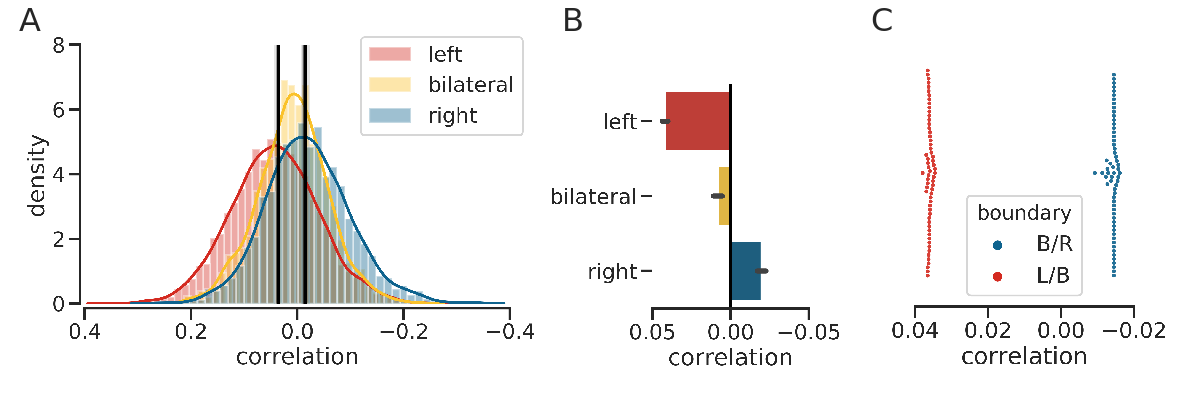

In [47]:
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_axes([0.36, .999, 1, .7], xticklabels=[], yticklabels=[])
ax1.imshow(Image.open('../reports/figures/10-dynamite-plot.png'))

ax2 = fig.add_axes([0, 1, 1, 0.8], xticklabels=[], yticklabels=[])
ax2.imshow(Image.open('../reports/figures/10-distribution-plot.png'))

ax3 = fig.add_axes([0.65, 1, 1, 0.8], xticklabels=[], yticklabels=[])
ax3.imshow(Image.open('../reports/figures/10-boundary-swarm-plot.png'))

plt.text(0,1, 'A',transform=ax2.transAxes, fontsize=32)
plt.text(1.04,1, 'B',transform=ax2.transAxes, fontsize=32)
plt.text(1.63,1, 'C',transform=ax2.transAxes, fontsize=32)

plt.savefig('../reports/figures/10-training-overview.png',dpi=300,bbox_inches='tight')
plt.show()

### make predictions for all patients (conc and inconc)

#### invert

In [48]:
all_inv_df = group_df*conds

In [ ]:
all_inv_df.tail()

In [50]:
def make_preds(this_df,clf,my_scaler,my_labeler):
    '''apply fitted classifier to the held-out patient;
    based on what has been done during training, we
    * scale the features using the stored scaler
    * transform the labels using the stored labeler
    * apply the classifier using the stored classfier
    '''
    
    scaled_features = my_scaler.transform(this_df.T)
    predictions = clf.predict(scaled_features)
    labeled_predictions = my_labeler.inverse_transform(predictions)
        
    counts = pd.Series(labeled_predictions).value_counts()
    counts_df = pd.DataFrame(counts).T
    counts_df.index = pd.MultiIndex.from_tuples(this_df.index)
    
    return counts_df

Example:

In [ ]:
make_preds(all_inv_df.iloc[[-1]],example_clf, example_scaler, example_labeler)

In [52]:
import warnings
# this is necessary to get rid of https://github.com/scikit-learn/scikit-learn/issues/10449
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

    for p in tqdm.tqdm(all_inv_df.index):

        # get data in leave-one-out fashion
        this_df = all_inv_df.loc[[p],:]
        other_df = stack_df.drop(p[-1],level=1)

        # train on this fold's data
        clf,my_scaler,my_labeler = train_classifier(other_df)
        # make predictions
        p_df = make_preds(this_df,clf,my_scaler,my_labeler)

        out_name = '../data/processed/csv/%s_counts_df.csv' % p[-1]
        p_df.to_csv(out_name)
        data_df.loc[p,'counts_df'] = out_name

data_df.to_csv('../data/processed/csv/info_epi_zscored_zdiff_summarymaps_2dpredclean_corr_counts_df.csv') 

100%|██████████| 96/96 [07:08<00:00,  4.45s/it]


### train classifier once on all data and store

We store a classifer trained on all data as a pickle file so we can re-use it in the future on new data

In [53]:
clf,my_scaler,my_labeler = train_classifier(stack_df)
d = {'clf':clf,'scaler':my_scaler,'labeler':my_labeler}

In [54]:
with open('../models/volume_clf.p','wb') as f:
    pickle.dump(d,f)

#### toolbox model

The toolbox assumes that a dataset used as input is a new dataset and was not part of this study

In [55]:
#clf_file = os.path.join(supDir,'models','volume_clf.p')
#with open(clf_file,'rb') as f:
#    clf_dict = pickle.load(f)
#    
#clf = clf_dict['clf']
#my_scaler = clf_dict['scaler']
#my_labeler = clf_dict['labeler']

In [56]:
#def make_p(pFolder,pName,clf=clf,my_scaler=my_scaler,my_labeler=my_labeler):
#    
#    filename = os.path.join(pFolder, ''.join([ pName, '_corr_df.csv']))
#    this_df = pd.read_csv(filename, index_col=[0], header=0)
#    this_df.index = [['correlations'],[pName]]
#    inv_df = this_df*conds
#    counts_df = make_preds(inv_df,clf,my_scaler,my_labeler)
#
#    out_name = os.path.join(pFolder, ''.join([ pName, '_counts_df.csv']))
#    counts_df.to_csv(out_name)
#
#    return out_name

### summary

For each patient, a classfier has been developed based on all the other patient (Leave-One-Out) and applied to the 200 volumes of that patient. There are now 200 decisions for each patient, as many as there are volumes. These data are stored in csv files which we can now access to make a prediction on the level of the patient.  


**************

< [Previous](09-mw-correlations-with-template.ipynb) | [Contents](00-mw-overview-notebook.ipynb) | [Next >](11-mw-logistic-regression.ipynb)